In [82]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.applications import InceptionV3, VGG19
import matplotlib.pyplot as plt

## Задание 1

In [186]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data3/data3", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(400,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


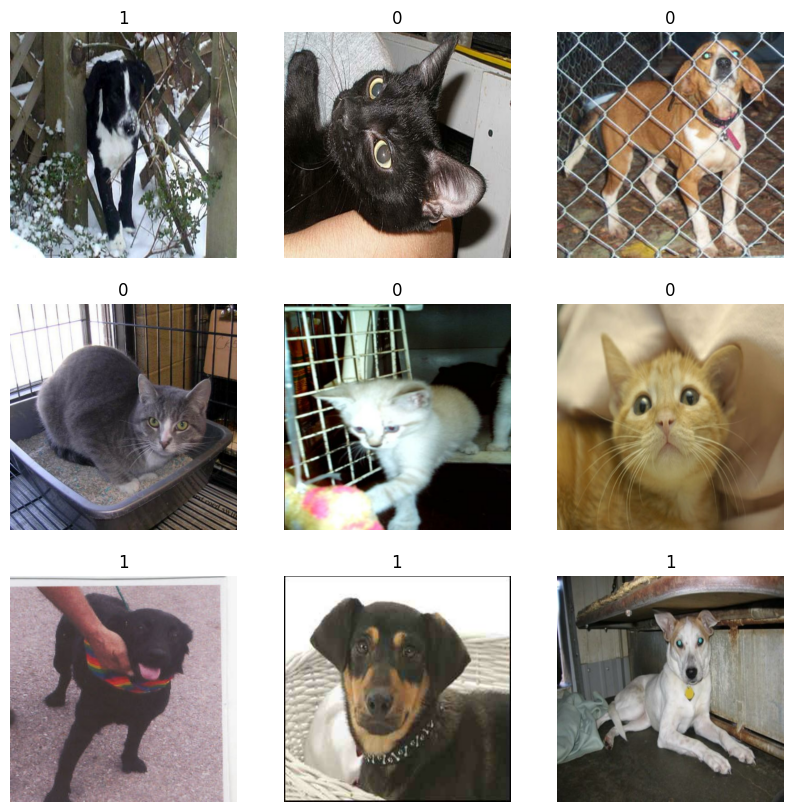

In [187]:

plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [188]:
image_datagen = ImageDataGenerator(
    rescale=1./255, # Масштабирование значений пикселей в диапазон [0, 1]
    rotation_range=20, # Случайное вращение изображения на угол в диапазоне [-20, 20]
    width_shift_range=0.2, # Случайное горизонтальное смещение (доля от ширины изображения)
    height_shift_range=0.2, # Случайное вертикальное смещение (доля от высоты изображения)
    shear_range=0.2, # Случайное сдвигание (сдвиг угла сдвига в градусах)
    zoom_range=0.2, # Случайное масштабирование изображения
    horizontal_flip=True) # Случайное отражение изображения по горизонтали

In [189]:
model = tf.keras.Sequential([
    # сверточный слой Conv2D с функцией активации ReLU для извлечения признаков
    # Сверточный слой Conv2D извлекает пространственные признаки изображений с помощью свертки с ядром на входных данных
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)), 
    # Слой пулинга MaxPooling2D уменьшает размерность изображений, улавливая наиболее значимую информацию
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # плоский слой Flatten преобразует данные в одномерный вектор
    tf.keras.layers.Flatten(),
    # Полносвязный слой Dense выполняет операции линейной и нелинейной трансформации выходов предыдущего слоя.
    tf.keras.layers.Dense(64, activation='relu'),
    # Выходной слой Dense используется для получения окончательных прогнозов модели. 
    # У нас только один нейрон с функцией активации сигмоида, который представляет вероятности принадлежности к классу "собака" или "кошка".
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [223]:
image_generator = image_datagen.flow_from_directory(
    '../data3/data3',
    target_size=(400, 400),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [192]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

In [193]:
model.fit(image_generator, epochs=2)

Epoch 1/2
63/63 [==============================] - 247s 4s/step - loss: 2.0067 - accuracy: 0.5370
Epoch 2/2
63/63 [==============================] - 213s 3s/step - loss: 0.6910 - accuracy: 0.5145


In [194]:
test_loss, test_accuracy = model.evaluate(image_generator)

63/63 [==============================] - 160s 3s/step - loss: 0.6898 - accuracy: 0.5030


## Задание 2

### VGG19

In [195]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../d8/101_ObjectCategories", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(400,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 273 files belonging to 3 classes.
Using 233 files for training.
Using 40 files for validation.


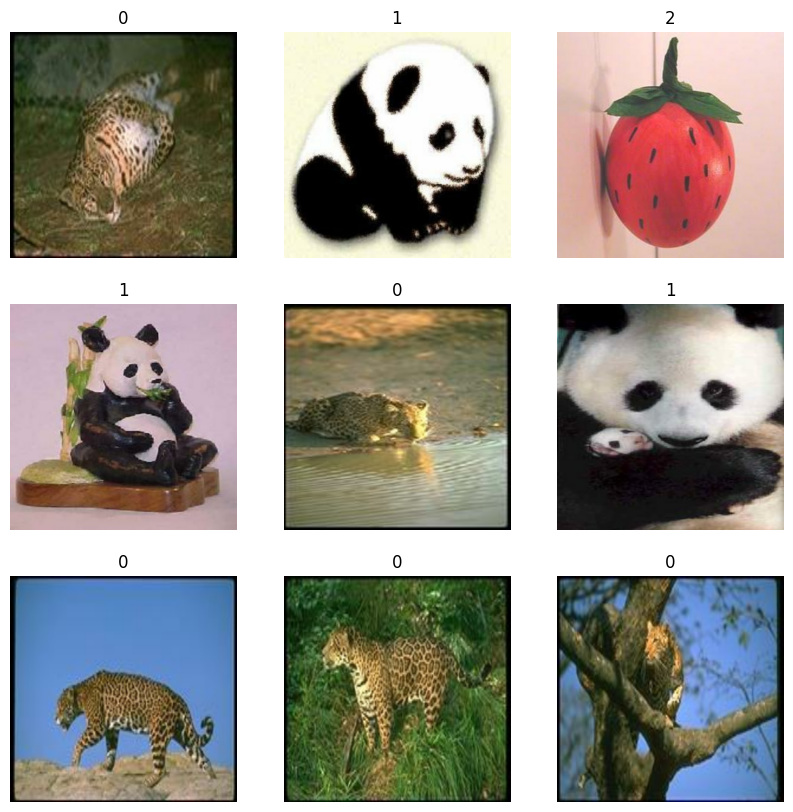

In [196]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [197]:
image_generator = image_datagen.flow_from_directory(
    '../d8/101_ObjectCategories',
    target_size=(400,400),
    batch_size=32)

Found 273 images belonging to 3 classes.


In [198]:
# загружаем предварительно обученную сеть VGG19
# параметр include_top со значением true указывает, что вместе со сверточными будут загружены
# полносвязные слои
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 78s 1us/step


In [199]:
# "заморозим" все слои, кроме последнего
for layer in vgg.layers:
    layer.trainable = False
vgg.layers[-1].trainable = True
vgg.layers[-3].trainable = True

In [201]:
model_vgg = Sequential()
model_vgg.add(vgg)
model_vgg.add(GlobalAveragePooling2D())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dense(3, activation='softmax'))

In [202]:
model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [203]:
model_vgg.fit(image_generator, epochs=2)

Epoch 1/2
9/9 [==============================] - 114s 12s/step - loss: 0.5021 - accuracy: 0.8132
Epoch 2/2
9/9 [==============================] - 111s 12s/step - loss: 0.1570 - accuracy: 0.9597


### InceptionV3

In [204]:
inv3 = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 102s 1us/step


In [205]:
# "заморозим" все слои, кроме последнего
for layer in inv3.layers:
    layer.trainable = False
inv3.layers[-1].trainable = True
inv3.layers[-3].trainable = True

In [207]:
model_inception = Sequential()
model_inception.add(inv3)
model_inception.add(GlobalAveragePooling2D())
model_inception.add(Dense(256, activation='relu'))
model_inception.add(Dense(3, activation='softmax'))

In [208]:
model_inception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [209]:
model_inception.fit(image_generator, epochs=2)

Epoch 1/2
9/9 [==============================] - 38s 3s/step - loss: 0.4046 - accuracy: 0.8388
Epoch 2/2
9/9 [==============================] - 28s 3s/step - loss: 0.0271 - accuracy: 0.9927
